In [1]:
import requests
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import calendar
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.stats import ttest_ind, f_oneway

In [50]:
# Check if the DataFrame file already exists
path = 'C:/Users/numan/Downloads/Datasets/energy_data.pkl'
df = os.path.exists(path)

if df:
    print(f"Dataset file '{path}' already exists. Skip dataset creation.")

In [2]:
# link for fetching data using helsinki-openapi.nuuka.cloud API
list_properties_url = "https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/List"
property_search_url = "https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/Search"
hourly_electricity_url = "https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/Hourly/ListByProperty"

In [3]:
# Fetch all property data
response_properties = requests.get(list_properties_url)
properties_data = response_properties.json()
print(properties_data[:5])

[{'locationName': '1000 Hakaniemen kauppahalli', 'propertyName': '1000 Hakaniemen kauppahalli', 'propertyCode': '091-011-9902-0101'}, {'locationName': '1001 Hietalahden kauppahalli', 'propertyName': '1001 Hietalahden kauppahalli', 'propertyCode': '091-004-9902-0008'}, {'locationName': '1002 Vanha kauppahalli', 'propertyName': '1002 Vanha kauppahalli', 'propertyCode': '091-003-9906-0101'}, {'locationName': '1037 Vuotalo', 'propertyName': '1037 Vuotalo', 'propertyCode': '091-054-0179-0003'}, {'locationName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen', 'propertyName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen', 'propertyCode': '091-040-0024-0003'}]


In [4]:
# Extract relevant property information
property_locations = [property_info['locationName'] for property_info in properties_data]
print(property_locations[:5])

['1000 Hakaniemen kauppahalli', '1001 Hietalahden kauppahalli', '1002 Vanha kauppahalli', '1037 Vuotalo', '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen']


In [6]:
# Function to fetch additional property information
def fetch_additional_property_info(location_name):
    search_params = {
        "SearchString": location_name,
        "SearchFromRecord": "LocationName"
    }
    try:
        response_property_search = requests.get(property_search_url, params=search_params)
        # Raise an error for bad responses
        response_property_search.raise_for_status()  
        property_info = response_property_search.json()
        return property_info
    except requests.RequestException as e:
        print(f"Error fetching property info for {location_name}: {e}")
        return None

In [7]:
def fetch_all_property_info_parallel(property_locations, batch_size=10):
    with ThreadPoolExecutor(max_workers=10) as executor:
        property_info_list = []
        futures = []

        for i in range(0, len(property_locations), batch_size):
            batch_locations = property_locations[i:i + batch_size]

            # Submit tasks for each location in the batch
            batch_futures = [executor.submit(fetch_additional_property_info, loc) for loc in batch_locations]
            futures.extend(batch_futures)

        # Iterate over completed futures and get results as soon as they are available
        for future in as_completed(futures):
            try:
                result = future.result()
                if result:
                    property_info_list.append(result)
            except Exception as e:
                print(f"Error processing future result: {e}")

    return property_info_list

In [8]:
property_info_list = fetch_all_property_info_parallel(property_locations)
property_info_list[0]

Error fetching property info for 2287 Lpk Lasten Kartano/Malmink. NT: 404 Client Error: Not Found for url: https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/Search?SearchString=2287+Lpk+Lasten+Kartano%2FMalmink.+NT&SearchFromRecord=LocationName
Error fetching property info for 6844 Paviljonki- lpk Kukkaniitty ja Blomängen: 404 Client Error: Not Found for url: https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/Search?SearchString=6844+Paviljonki-+lpk+Kukkaniitty+ja+Blom%C3%A4ngen&SearchFromRecord=LocationName
Error fetching property info for 2070 Sophie Mannerheimin koulu/Välskärin: 404 Client Error: Not Found for url: https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/Search?SearchString=2070+Sophie+Mannerheimin+koulu%2FV%C3%A4lsk%C3%A4rin&SearchFromRecord=LocationName


[{'locationName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen',
  'propertyName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen',
  'propertyCode': '091-040-0024-0003',
  'yearOfIntroduction': '1981-01-01T00:00:00',
  'purposeOfUse': 'G monitoimitalo',
  'totalArea': 7354.0,
  'heatedArea': 6150.9,
  'volume': 33650.0,
  'buildingType': 'OtherAssemblyBuilding',
  'latitude': '60.2754845',
  'longitude': '24.9974220',
  'reportingGroups': [{'name': 'Electricity',
    'energyType': 'Electricity',
    'isTopGroup': True},
   {'name': 'Heat', 'energyType': 'Heating', 'isTopGroup': True},
   {'name': 'Water', 'energyType': 'Water', 'isTopGroup': True}],
  'buildings': [{'locationName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen,  21715 monitoimitalo',
    'propertyName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen',
    'propertyCode': '091-040-0024-0003',
    'buildingCode': '1021839448',
    'yearOfIntroduction': '1981-01-01T00:00:00',
    'p

In [9]:
# Create a DataFrame from the additional property information
property_df = pd.DataFrame(property_info_list)
property_df.head()

0     1
0  {'locationName': '1507 Suutarilan monitoimital...  None
1  {'locationName': '1037 Vuotalo', 'propertyName...  None
2  {'locationName': '1512 Malmin raitti 3', 'prop...  None
3  {'locationName': '1513 Psykiatrinen poliklinik...  None
4  {'locationName': '1509 Lpk Karvikka ja rppk Le...  None

In [10]:
property_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       848 non-null    object
 1   1       6 non-null      object
dtypes: object(2)
memory usage: 13.4+ KB


In [11]:
# Drop the second column
property_df = property_df.drop(1, axis=1)
property_df.head()

0
0  {'locationName': '1507 Suutarilan monitoimital...
1  {'locationName': '1037 Vuotalo', 'propertyName...
2  {'locationName': '1512 Malmin raitti 3', 'prop...
3  {'locationName': '1513 Psykiatrinen poliklinik...
4  {'locationName': '1509 Lpk Karvikka ja rppk Le...

In [12]:
print(property_df.iloc[0, 0])

{'locationName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen', 'propertyName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen', 'propertyCode': '091-040-0024-0003', 'yearOfIntroduction': '1981-01-01T00:00:00', 'purposeOfUse': 'G monitoimitalo', 'totalArea': 7354.0, 'heatedArea': 6150.9, 'volume': 33650.0, 'buildingType': 'OtherAssemblyBuilding', 'latitude': '60.2754845', 'longitude': '24.9974220', 'reportingGroups': [{'name': 'Electricity', 'energyType': 'Electricity', 'isTopGroup': True}, {'name': 'Heat', 'energyType': 'Heating', 'isTopGroup': True}, {'name': 'Water', 'energyType': 'Water', 'isTopGroup': True}], 'buildings': [{'locationName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen,  21715 monitoimitalo', 'propertyName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen', 'propertyCode': '091-040-0024-0003', 'buildingCode': '1021839448', 'yearOfIntroduction': '1981-01-01T00:00:00', 'purposeOfUse': 'G monitoimitalo', 'totalArea': 7354.0, 'heat

In [13]:
# Creating an empty list to store dictionaries
property_info_list = []

# Process row function
def process_row(row):
    try:
        if isinstance(row, str):
            cell_data = json.loads(row)
        elif isinstance(row, dict):
            cell_data = row
        else:
            raise ValueError(f"Unsupported data type: {type(row)}")

        # Using only necessary columns
        extracted_data = {
            'locationName': cell_data.get('locationName'),
            'propertyName': cell_data.get('propertyName'),
            'propertyCode': cell_data.get('propertyCode'),
            'yearOfIntroduction': cell_data.get('yearOfIntroduction'),
            'purposeOfUse': cell_data.get('purposeOfUse'),
            'totalArea': cell_data.get('totalArea'),
            'heatedArea': cell_data.get('heatedArea'),
            'volume': cell_data.get('volume'),
            'buildingType': cell_data.get('buildingType'),
            'latitude': cell_data.get('latitude'),
            'longitude': cell_data.get('longitude')
        }
        property_info_list.append(extracted_data)
    except (json.JSONDecodeError, AttributeError, ValueError):
        pass

# Apply the processing function to each cell in the DataFrame for additional_df
property_df.applymap(process_row)

# Create a DataFrame from the list of dictionaries
property_info_df = pd.DataFrame(property_info_list)
property_info_df.head()

locationName  \
0  1507 Suutarilan monitoimitalo/ala-aste ja Lpk ...   
1                                       1037 Vuotalo   
2                               1512 Malmin raitti 3   
3                     1513 Psykiatrinen poliklinikka   
4                 1509 Lpk Karvikka ja rppk Lemmikki   

                                        propertyName       propertyCode  \
0  1507 Suutarilan monitoimitalo/ala-aste ja Lpk ...  091-040-0024-0003   
1                                       1037 Vuotalo  091-054-0179-0003   
2                               1512 Malmin raitti 3  091-038-0107-0016   
3                     1513 Psykiatrinen poliklinikka  091-022-0548-0043   
4                 1509 Lpk Karvikka ja rppk Lemmikki  091-038-0055-0010   

    yearOfIntroduction         purposeOfUse  totalArea  heatedArea   volume  \
0  1981-01-01T00:00:00      G monitoimitalo     7354.0      6150.9  33650.0   
1  2001-01-01T00:00:00      G monitoimitalo     6426.0      4643.9  32415.0   
2  1929-01-01T00:00:00  G muu kokoontuminen      821.0       542.0   2717.0   
3  1958-01-01T00:00:00           D toimisto     3296.0      2079.0  10793.0   
4  1980-01-01T00:00:00   F lasten päiväkoti     1468.0      1216.5   5354.0   

            buildingType    latitude   longitude  
0  OtherAssemblyBuilding  60.2754845  24.9974220  
1  OtherAssemblyBuilding  60.2088024  25.1433085  
2                 Office  60.2528190  25.0081551  
3                 Office  60.1934923  24.9553642  
4                Nursery  60.2449607  25.0077957

In [14]:
property_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   locationName        848 non-null    object 
 1   propertyName        842 non-null    object 
 2   propertyCode        838 non-null    object 
 3   yearOfIntroduction  794 non-null    object 
 4   purposeOfUse        840 non-null    object 
 5   totalArea           834 non-null    float64
 6   heatedArea          828 non-null    float64
 7   volume              836 non-null    float64
 8   buildingType        848 non-null    object 
 9   latitude            845 non-null    object 
 10  longitude           845 non-null    object 
dtypes: float64(3), object(8)
memory usage: 73.0+ KB


In [15]:
# Unique values of each column
unique_counts = property_info_df.nunique()

# Display the counts
print(unique_counts)

locationName          758
propertyName          755
propertyCode          643
yearOfIntroduction    118
purposeOfUse           34
totalArea             636
heatedArea            630
volume                602
buildingType           31
latitude              731
longitude             732
dtype: int64


In [16]:
# Function to fetch hourly electricity data for a property
def fetch_hourly_data_for_property(property_location):
    start_date = datetime.strptime("2020-01-01", "%Y-%m-%d")
    end_date = datetime.strptime("2023-10-31", "%Y-%m-%d")
    
    current_date = start_date
    all_hourly_data = [] 

    while current_date <= end_date:
        six_months_later = current_date + timedelta(days=180)
        last_day_of_six_months = (six_months_later.replace(day=1) - timedelta(days=1)).replace(hour=23, minute=59, second=59)
        next_interval_start = last_day_of_six_months + timedelta(days=1)
        next_date = min(next_interval_start, end_date)

        hourly_params = {
            "Record": "LocationName",
            "SearchString": property_location,
            "ReportingGroup": "Electricity",
            "StartTime": current_date.strftime("%Y-%m-%d"),
            "EndTime": next_date.strftime("%Y-%m-%d")
        }

        try:
            response_hourly_electricity = requests.get(hourly_electricity_url, params=hourly_params)
            response_hourly_electricity.raise_for_status()  
            hourly_electricity_data = response_hourly_electricity.json()
            
            all_hourly_data.append(hourly_electricity_data)

        except requests.RequestException as e:
            raise e
        
        current_date = next_interval_start

    return all_hourly_data  


In [17]:
def fetch_hourly_data_for_property_parallel(property_locations):
    with ThreadPoolExecutor(max_workers=10) as executor:
        hourly_data_list = []

        for property_location in property_locations:
            # Submit a task for each location
            future = executor.submit(fetch_hourly_data_for_property, property_location)
            
            try:
                result = future.result()
                if result:
                    hourly_data_list.extend(result)  # Extend the list with results
            except requests.RequestException as e:
                # Centralized error handling
                print(f"Error fetching hourly data for location {property_location}: {e}")

    return hourly_data_list

In [18]:
hourly_data_list = fetch_hourly_data_for_property_parallel(property_locations)
hourly_data_list[0]

Error fetching hourly data for location 1511 Pauligin huvila (disabled): 404 Client Error: Not Found for url: https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/Hourly/ListByProperty?Record=LocationName&SearchString=1511+Pauligin+huvila+%28disabled%29&ReportingGroup=Electricity&StartTime=2023-05-01&EndTime=2023-10-01
Error fetching hourly data for location 1512 Malmin raitti 3: 404 Client Error: Not Found for url: https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/Hourly/ListByProperty?Record=LocationName&SearchString=1512+Malmin+raitti+3&ReportingGroup=Electricity&StartTime=2022-07-01&EndTime=2022-12-01
Error fetching hourly data for location 1540 Virastotalo, Dagmarinkatu 6 (disabled): 404 Client Error: Not Found for url: https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/Hourly/ListByProperty?Record=LocationName&SearchString=1540+Virastotalo%2C+Dagmarinkatu+6+%28disabled%29&ReportingGroup=Electricity&StartTime=2023-05-01&EndTime=2023-10-01
Error fetching hourly dat

[{'timestamp': '2020-01-01T00:00:00',
  'reportingGroup': 'Electricity',
  'locationName': '1000 Hakaniemen kauppahalli',
  'value': 0.06,
  'unit': 'kWh'},
 {'timestamp': '2020-01-01T01:00:00',
  'reportingGroup': 'Electricity',
  'locationName': '1000 Hakaniemen kauppahalli',
  'value': 0.060000000000000005,
  'unit': 'kWh'},
 {'timestamp': '2020-01-01T02:00:00',
  'reportingGroup': 'Electricity',
  'locationName': '1000 Hakaniemen kauppahalli',
  'value': 0.060000000000000005,
  'unit': 'kWh'},
 {'timestamp': '2020-01-01T03:00:00',
  'reportingGroup': 'Electricity',
  'locationName': '1000 Hakaniemen kauppahalli',
  'value': 0.07,
  'unit': 'kWh'},
 {'timestamp': '2020-01-01T04:00:00',
  'reportingGroup': 'Electricity',
  'locationName': '1000 Hakaniemen kauppahalli',
  'value': 0.06,
  'unit': 'kWh'},
 {'timestamp': '2020-01-01T05:00:00',
  'reportingGroup': 'Electricity',
  'locationName': '1000 Hakaniemen kauppahalli',
  'value': 0.060000000000000005,
  'unit': 'kWh'},
 {'timesta

In [135]:
# Convert the list of dictionaries to a DataFrame
all_properties_hourly_electricity_df = pd.DataFrame(hourly_data_list)

# Display the DataFrame
print("\nDaily Electricity Data for All Properties:")
all_properties_hourly_electricity_df.head()


Daily Electricity Data for All Properties:


0      \
0  {'timestamp': '2020-01-01T00:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T00:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T00:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T00:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T00:00:00', 'reportin...   

                                               1      \
0  {'timestamp': '2020-01-01T01:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T01:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T01:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T01:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T01:00:00', 'reportin...   

                                               2      \
0  {'timestamp': '2020-01-01T02:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T02:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T02:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T02:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T02:00:00', 'reportin...   

                                               3      \
0  {'timestamp': '2020-01-01T03:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T03:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T03:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T03:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T03:00:00', 'reportin...   

                                               4      \
0  {'timestamp': '2020-01-01T04:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T04:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T04:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T04:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T04:00:00', 'reportin...   

                                               5      \
0  {'timestamp': '2020-01-01T05:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T05:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T05:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T05:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T05:00:00', 'reportin...   

                                               6      \
0  {'timestamp': '2020-01-01T06:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T06:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T06:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T06:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T06:00:00', 'reportin...   

                                               7      \
0  {'timestamp': '2020-01-01T07:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T07:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T07:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T07:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T07:00:00', 'reportin...   

                                               8      \
0  {'timestamp': '2020-01-01T08:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T08:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T08:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T08:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T08:00:00', 'reportin...   

                                               9      ... 50373 50374 50375  \
0  {'timestamp': '2020-01-01T09:00:00', 'reportin...  ...  None  None  None   
1  {'timestamp': '2020-06-01T09:00:00', 'reportin...  ...  None  None  None   
2  {'timestamp': '2020-11-01T09:00:00', 'reportin...  ...  None  None  None   
3  {'timestamp': '2021-04-01T09:00:00', 'reportin...  ...  None  None  None   
4  {'timestamp': '2021-09-01T09:00:00', 'reportin...  ...  None  None  None   

  50376 50377 50378 50379 50380 50381 50382  
0  None  None  None  None  None  None  None  
1  None  None  None  None  None  None  None  
2  None  None  None  None  None  None  None  
3  None  None  None  None  None  None  None  
4  None  None  None  None  None  None  None  

[5 rows x 50383 columns]

In [136]:
# Print null values of each column
missing_values = pd.concat([all_properties_hourly_electricity_df.isnull().sum(), (all_properties_hourly_electricity_df.isnull().sum() / len(all_properties_hourly_electricity_df) * 100)], axis=1, keys=['Missing Values', '% Missing']).sort_values(by='Missing Values', ascending=False)
missing_values

Missing Values  % Missing
25191            5059  99.980237
33581            5059  99.980237
33583            5059  99.980237
33584            5059  99.980237
33585            5059  99.980237
...               ...        ...
48                  0   0.000000
49                  0   0.000000
50                  0   0.000000
51                  0   0.000000
0                   0   0.000000

[50383 rows x 2 columns]

In [137]:
# Set a threshold for the percentage of missing values
threshold = 80  
# Filter columns with missing values exceeding the threshold
columns_to_drop = missing_values[missing_values['% Missing'] > threshold].index

# Drop the columns with a high percentage of missing values
all_properties_hourly_electricity_df.drop(columns=columns_to_drop, inplace=True)

# Display the modified DataFrame
all_properties_hourly_electricity_df.head()

0     \
0  {'timestamp': '2020-01-01T00:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T00:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T00:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T00:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T00:00:00', 'reportin...   

                                                1     \
0  {'timestamp': '2020-01-01T01:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T01:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T01:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T01:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T01:00:00', 'reportin...   

                                                2     \
0  {'timestamp': '2020-01-01T02:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T02:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T02:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T02:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T02:00:00', 'reportin...   

                                                3     \
0  {'timestamp': '2020-01-01T03:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T03:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T03:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T03:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T03:00:00', 'reportin...   

                                                4     \
0  {'timestamp': '2020-01-01T04:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T04:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T04:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T04:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T04:00:00', 'reportin...   

                                                5     \
0  {'timestamp': '2020-01-01T05:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T05:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T05:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T05:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T05:00:00', 'reportin...   

                                                6     \
0  {'timestamp': '2020-01-01T06:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T06:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T06:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T06:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T06:00:00', 'reportin...   

                                                7     \
0  {'timestamp': '2020-01-01T07:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T07:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T07:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T07:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T07:00:00', 'reportin...   

                                                8     \
0  {'timestamp': '2020-01-01T08:00:00', 'reportin...   
1  {'timestamp': '2020-06-01T08:00:00', 'reportin...   
2  {'timestamp': '2020-11-01T08:00:00', 'reportin...   
3  {'timestamp': '2021-04-01T08:00:00', 'reportin...   
4  {'timestamp': '2021-09-01T08:00:00', 'reportin...   

                                                9     ...  \
0  {'timestamp': '2020-01-01T09:00:00', 'reportin...  ...   
1  {'timestamp': '2020-06-01T09:00:00', 'reportin...  ...   
2  {'timestamp': '2020-11-01T09:00:00', 'reportin...  ...   
3  {'timestamp': '2021-04-01T09:00:00', 'reportin...  ...   
4  {'timestamp': '2021-09-01T09:00:00', 'reportin...  ...   

                                                3663  \
0                                               None   
1  {'timestamp': '2020-10-31T15:00:00', 'reportin...   
2                                               None   
3  {'timestamp': '2021-08-31T15:00:00', 'reportin...   
4  {'timestamp': '2022-01-31T15:00:00', 'reportin...   

                                                3664  \
0                                               None   
1  {'timestamp': '2020-10-31T16:00:00', 'reportin...   
2                                               None   
3  {'timestamp': '2021-08-31T16:00:00', 'reportin...   
4  {'timestamp': '2022-01-31T16

In [138]:
print(all_properties_hourly_electricity_df.iloc[0, 0])

{'timestamp': '2020-01-01T00:00:00', 'reportingGroup': 'Electricity', 'locationName': '1000 Hakaniemen kauppahalli', 'value': 0.06, 'unit': 'kWh'}


In [139]:
# Creating an empty list to store dictionaries 
data_list = []

# Iterate over DataFrame rows using apply
def process_row(row):
    try:
        if isinstance(row, str):
            cell_data = json.loads(row)
        elif isinstance(row, dict):
            cell_data = row
        else:
            raise ValueError(f"Unsupported data type: {type(row)}")

        extracted_data = {
            'timestamp': cell_data.get('timestamp'),
            'reportingGroup': cell_data.get('reportingGroup'),
            'locationName': cell_data.get('locationName'),
            'consumption': cell_data.get('value'),
            'unit': cell_data.get('unit')
        }
        data_list.append(extracted_data)
    except (json.JSONDecodeError, AttributeError, ValueError):
        pass

# Apply the processing function to each cell in the DataFrame
all_properties_hourly_electricity_df.applymap(process_row)

# Create a DataFrame from the list of dictionaries
hourly_energy_df = pd.DataFrame(data_list)
hourly_energy_df.head()

timestamp reportingGroup                 locationName  \
0  2020-01-01T00:00:00    Electricity  1000 Hakaniemen kauppahalli   
1  2020-06-01T00:00:00    Electricity  1000 Hakaniemen kauppahalli   
2  2020-11-01T00:00:00    Electricity  1000 Hakaniemen kauppahalli   
3  2021-04-01T00:00:00    Electricity  1000 Hakaniemen kauppahalli   
4  2021-09-01T00:00:00    Electricity  1000 Hakaniemen kauppahalli   

   consumption unit  
0         0.06  kWh  
1         0.04  kWh  
2         0.04  kWh  
3         0.03  kWh  
4         0.04  kWh

In [140]:
hourly_energy_df.shape

(16893955, 5)

In [141]:
# Unique values of each column
unique_counts = hourly_energy_df.nunique()

# Display the counts
print(unique_counts)

timestamp          64173
reportingGroup         1
locationName         506
consumption       188522
unit                   1
dtype: int64


In [143]:
hourly_energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16893955 entries, 0 to 16893954
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   timestamp       object 
 1   reportingGroup  object 
 2   locationName    object 
 3   consumption     float64
 4   unit            object 
dtypes: float64(1), object(4)
memory usage: 644.5+ MB


In [144]:
# Final df after merging the energy_df with the additional_info_df based on 'locationName'
df = pd.merge(hourly_energy_df, property_info_df, on='locationName', how='left')
df.head()

timestamp reportingGroup                 locationName  \
0  2020-01-01T00:00:00    Electricity  1000 Hakaniemen kauppahalli   
1  2020-06-01T00:00:00    Electricity  1000 Hakaniemen kauppahalli   
2  2020-11-01T00:00:00    Electricity  1000 Hakaniemen kauppahalli   
3  2021-04-01T00:00:00    Electricity  1000 Hakaniemen kauppahalli   
4  2021-09-01T00:00:00    Electricity  1000 Hakaniemen kauppahalli   

   consumption unit                 propertyName       propertyCode  \
0         0.06  kWh  1000 Hakaniemen kauppahalli  091-011-9902-0101   
1         0.04  kWh  1000 Hakaniemen kauppahalli  091-011-9902-0101   
2         0.04  kWh  1000 Hakaniemen kauppahalli  091-011-9902-0101   
3         0.03  kWh  1000 Hakaniemen kauppahalli  091-011-9902-0101   
4         0.04  kWh  1000 Hakaniemen kauppahalli  091-011-9902-0101   

    yearOfIntroduction   purposeOfUse  totalArea  heatedArea   volume  \
0  1912-01-01T00:00:00  C kauppahalli     3669.0      2542.0  18966.0   
1  1912-01-01T00:00:00  C kauppahalli     3669.0      2542.0  18966.0   
2  1912-01-01T00:00:00  C kauppahalli     3669.0      2542.0  18966.0   
3  1912-01-01T00:00:00  C kauppahalli     3669.0      2542.0  18966.0   
4  1912-01-01T00:00:00  C kauppahalli     3669.0      2542.0  18966.0   

         buildingType    latitude   longitude  
0  ShoppingCenterMall  60.1790530  24.9511538  
1  ShoppingCenterMall  60.1790530  24.9511538  
2  ShoppingCenterMall  60.1790530  24.9511538  
3  ShoppingCenterMall  60.1790530  24.9511538  
4  ShoppingCenterMall  60.1790530  24.9511538

In [145]:
# Unique values of each column
unique_counts = df.nunique()

# Display the counts
print(unique_counts)

timestamp              64173
reportingGroup             1
locationName             506
consumption           188522
unit                       1
propertyName             506
propertyCode             472
yearOfIntroduction       104
purposeOfUse              30
totalArea                472
heatedArea               471
volume                   458
buildingType              29
latitude                 499
longitude                499
dtype: int64


In [146]:
df.shape

(16893955, 15)

In [58]:
# Save the DataFrame to a file for future use
df.to_pickle(path)

In [ ]:
# Creating df from existing file
df = pd.read_pickle(path)
df.head()

In [147]:
# Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create new columns for year, day, and hour
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day_name()
df['hour'] = df['timestamp'].dt.hour

# Drop the 'timestamp' column
df = df.drop(columns=['timestamp'])

In [148]:
# final_df shape
df.shape

(16893955, 18)

In [149]:
# Convert 'yearOfIntroduction' column to datetime
df['yearOfIntroduction'] = pd.to_datetime(df['yearOfIntroduction'])

# Create new columns for year, day, and hour
df['introductionYear'] = df['yearOfIntroduction'].dt.date

# Drop the 'yearOfIntroduction' column
df = df.drop(columns=['yearOfIntroduction'])

In [150]:
df.head()

reportingGroup                 locationName  consumption unit  \
0    Electricity  1000 Hakaniemen kauppahalli         0.06  kWh   
1    Electricity  1000 Hakaniemen kauppahalli         0.04  kWh   
2    Electricity  1000 Hakaniemen kauppahalli         0.04  kWh   
3    Electricity  1000 Hakaniemen kauppahalli         0.03  kWh   
4    Electricity  1000 Hakaniemen kauppahalli         0.04  kWh   

                  propertyName       propertyCode   purposeOfUse  totalArea  \
0  1000 Hakaniemen kauppahalli  091-011-9902-0101  C kauppahalli     3669.0   
1  1000 Hakaniemen kauppahalli  091-011-9902-0101  C kauppahalli     3669.0   
2  1000 Hakaniemen kauppahalli  091-011-9902-0101  C kauppahalli     3669.0   
3  1000 Hakaniemen kauppahalli  091-011-9902-0101  C kauppahalli     3669.0   
4  1000 Hakaniemen kauppahalli  091-011-9902-0101  C kauppahalli     3669.0   

   heatedArea   volume        buildingType    latitude   longitude  year  \
0      2542.0  18966.0  ShoppingCenterMall  60.1790530  24.9511538  2020   
1      2542.0  18966.0  ShoppingCenterMall  60.1790530  24.9511538  2020   
2      2542.0  18966.0  ShoppingCenterMall  60.1790530  24.9511538  2020   
3      2542.0  18966.0  ShoppingCenterMall  60.1790530  24.9511538  2021   
4      2542.0  18966.0  ShoppingCenterMall  60.1790530  24.9511538  2021   

   month        day  hour introductionYear  
0      1  Wednesday     0       1912-01-01  
1      6     Monday     0       1912-01-01  
2     11     Sunday     0       1912-01-01  
3      4   Thursday     0       1912-01-01  
4      9  Wednesday     0       1912-01-01

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16893955 entries, 0 to 16893954
Data columns (total 18 columns):
 #   Column            Dtype  
---  ------            -----  
 0   reportingGroup    object 
 1   locationName      object 
 2   consumption       float64
 3   unit              object 
 4   propertyName      object 
 5   propertyCode      object 
 6   purposeOfUse      object 
 7   totalArea         float64
 8   heatedArea        float64
 9   volume            float64
 10  buildingType      object 
 11  latitude          object 
 12  longitude         object 
 13  year              int32  
 14  month             int32  
 15  day               object 
 16  hour              int32  
 17  introductionYear  object 
dtypes: float64(4), int32(3), object(11)
memory usage: 2.1+ GB


In [152]:
# Print null values of each column
missing_values = pd.concat([df.isnull().sum(), (df.isnull().sum() / len(df) * 100)], axis=1, keys=['Missing Values', '% Missing']).sort_values(by='Missing Values', ascending=False)
print(missing_values)

                  Missing Values  % Missing
introductionYear          160976   0.952862
heatedArea                 57298   0.339163
totalArea                  26088   0.154422
volume                     26088   0.154422
propertyName                   0   0.000000
propertyCode                   0   0.000000
purposeOfUse                   0   0.000000
unit                           0   0.000000
consumption                    0   0.000000
locationName                   0   0.000000
buildingType                   0   0.000000
latitude                       0   0.000000
longitude                      0   0.000000
year                           0   0.000000
month                          0   0.000000
day                            0   0.000000
hour                           0   0.000000
reportingGroup                 0   0.000000


In [153]:
# Description of numeric cols of df
df.describe().T

count          mean           std     min      25%      50%  \
consumption  16893955.0     36.480334     79.458963   -11.7     5.68    14.72   
totalArea    16867867.0   4196.779541   5975.500079     0.0   899.00  2008.00   
heatedArea   16836657.0   3296.081522   4571.156591     0.0   750.00  1659.00   
volume       16867867.0  16341.097275  24356.909458     0.0  2894.00  7435.00   
year         16893955.0   2021.429750      1.097367  2020.0  2020.00  2021.00   
month        16893955.0      6.301163      3.362060     1.0     3.00     6.00   
hour         16893955.0     11.498973      6.923871     0.0     5.00    11.00   

                  75%       max  
consumption     36.14   29002.0  
totalArea     5426.00   46708.0  
heatedArea    4449.00   41947.6  
volume       20750.00  169631.0  
year          2022.00    2023.0  
month            9.00      12.0  
hour            18.00      23.0

In [154]:
# Unique values of each column
unique_counts = df.nunique()

# Display the counts
print(unique_counts)

reportingGroup           1
locationName           506
consumption         188522
unit                     1
propertyName           506
propertyCode           472
purposeOfUse            30
totalArea              472
heatedArea             471
volume                 458
buildingType            29
latitude               499
longitude              499
year                     4
month                   12
day                      7
hour                    24
introductionYear       104
dtype: int64


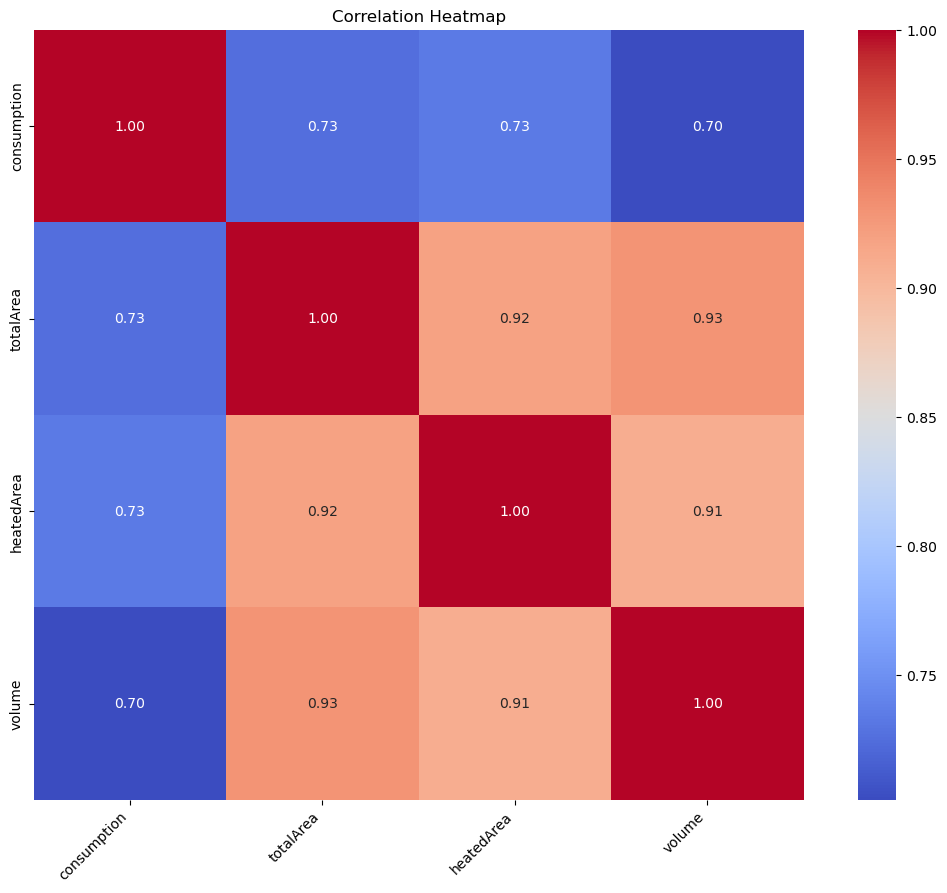

In [155]:
# Select only numeric columns for correlation
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
heatmap_check = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap="coolwarm", square=True)
heatmap_check.set_title("Correlation Heatmap")
plt.xticks(rotation=45, ha="right")
plt.show()

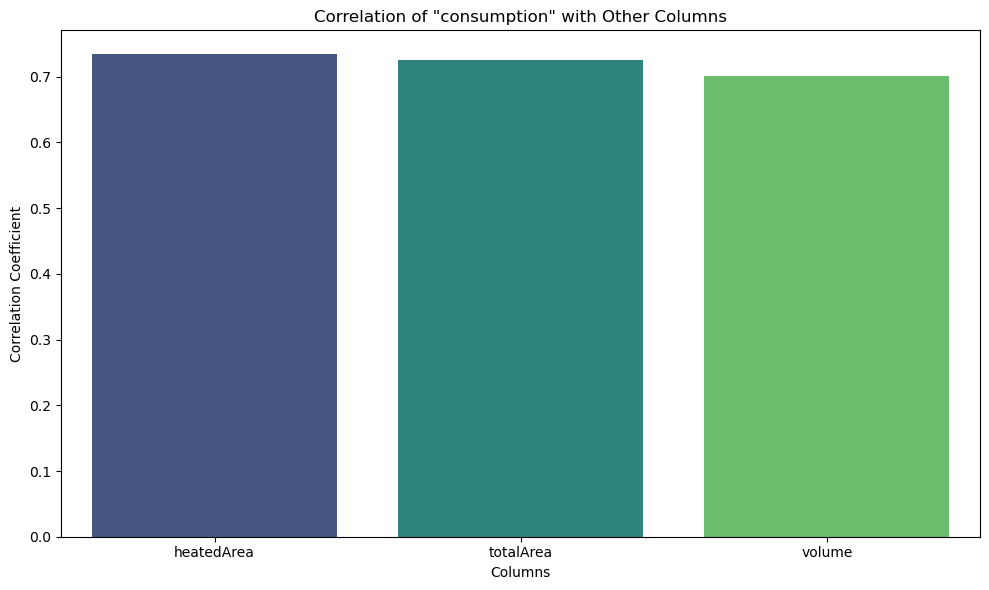

In [156]:
# Setting "consumption" as target
target_column = "consumption"

# Select only numeric columns for correlation
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlations of "consumption" with all other numeric columns
correlations = df[numeric_columns].corr()[target_column].sort_values(ascending=False)

# Exclude the target column from the correlations
correlations = correlations.drop(target_column, errors='ignore')

# Plot the correlations as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values, palette="viridis")
plt.title(f'Correlation of "{target_column}" with Other Columns')
plt.xlabel("Columns")
plt.ylabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

In [157]:
# Group by location and year, summing up the consumption
grouped_df = df.groupby(['locationName', 'year'])['consumption'].sum().reset_index()

# Create a list of all locations
all_locations = grouped_df['locationName'].unique()

# Create traces for each location
traces = [go.Scatter(x=grouped_df[grouped_df['locationName'] == location]['year'],
                     y=grouped_df[grouped_df['locationName'] == location]['consumption'],
                     mode='lines',
                     name='',
                     visible=(location == all_locations[0]),
                     hovertemplate='Location: %{text}<br>Year: %{x}<br>Consumption: %{y:.2f} kWh',
                     text=[location] * len(grouped_df[grouped_df['locationName'] == location]['year'])
                    ) for location in all_locations]

# Create layout with dropdown menu
layout = go.Layout(updatemenus=[dict(type='dropdown',
                                     direction='down',
                                     x=0.75,
                                     y=1.15,
                                     showactive=True,
                                     buttons=[dict(label=location,
                                                   method='update',
                                                   args=[{'visible': [location == trace.text[0] for trace in traces]}])
                                              for location in all_locations])],
                   title=dict(text='Total Yearly Consumption for Each Location',
                              x=0.5,
                              y=0.95,
                              xanchor='center',
                              yanchor='top'),
                   margin=dict(t=100),
                   xaxis=dict(title='Year'),
                   yaxis=dict(title='Consumption (kWh)'))

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Set the order of categories on the x-axis and type as 'category'
fig.update_xaxes(categoryorder="array", categoryarray=sorted(df['year'].unique()), type='category')

# Show the interactive plot
fig.show()

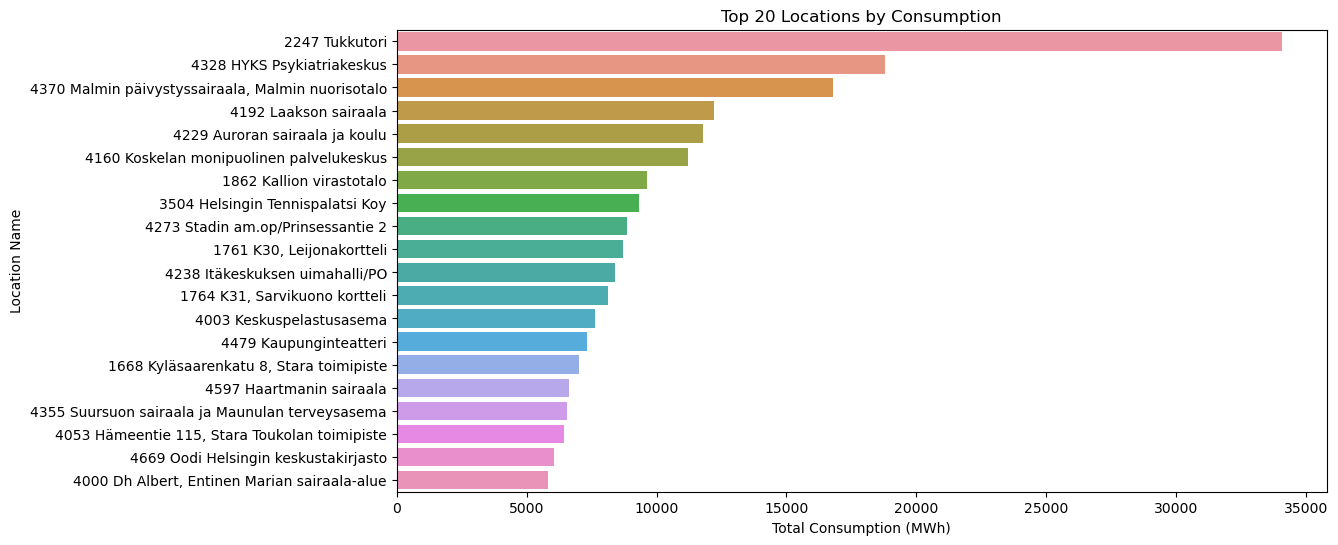

In [158]:
# Top 20 locations by consumption
top_locations = df.groupby('locationName')['consumption'].sum().nlargest(20) / 1000  # Convert from KWh to MWh

plt.figure(figsize=(12, 6))
sns.barplot(x=top_locations.values, y=top_locations.index)
plt.xlabel('Total Consumption (MWh)') 
plt.ylabel('Location Name')
plt.title('Top 20 Locations by Consumption')
plt.show()

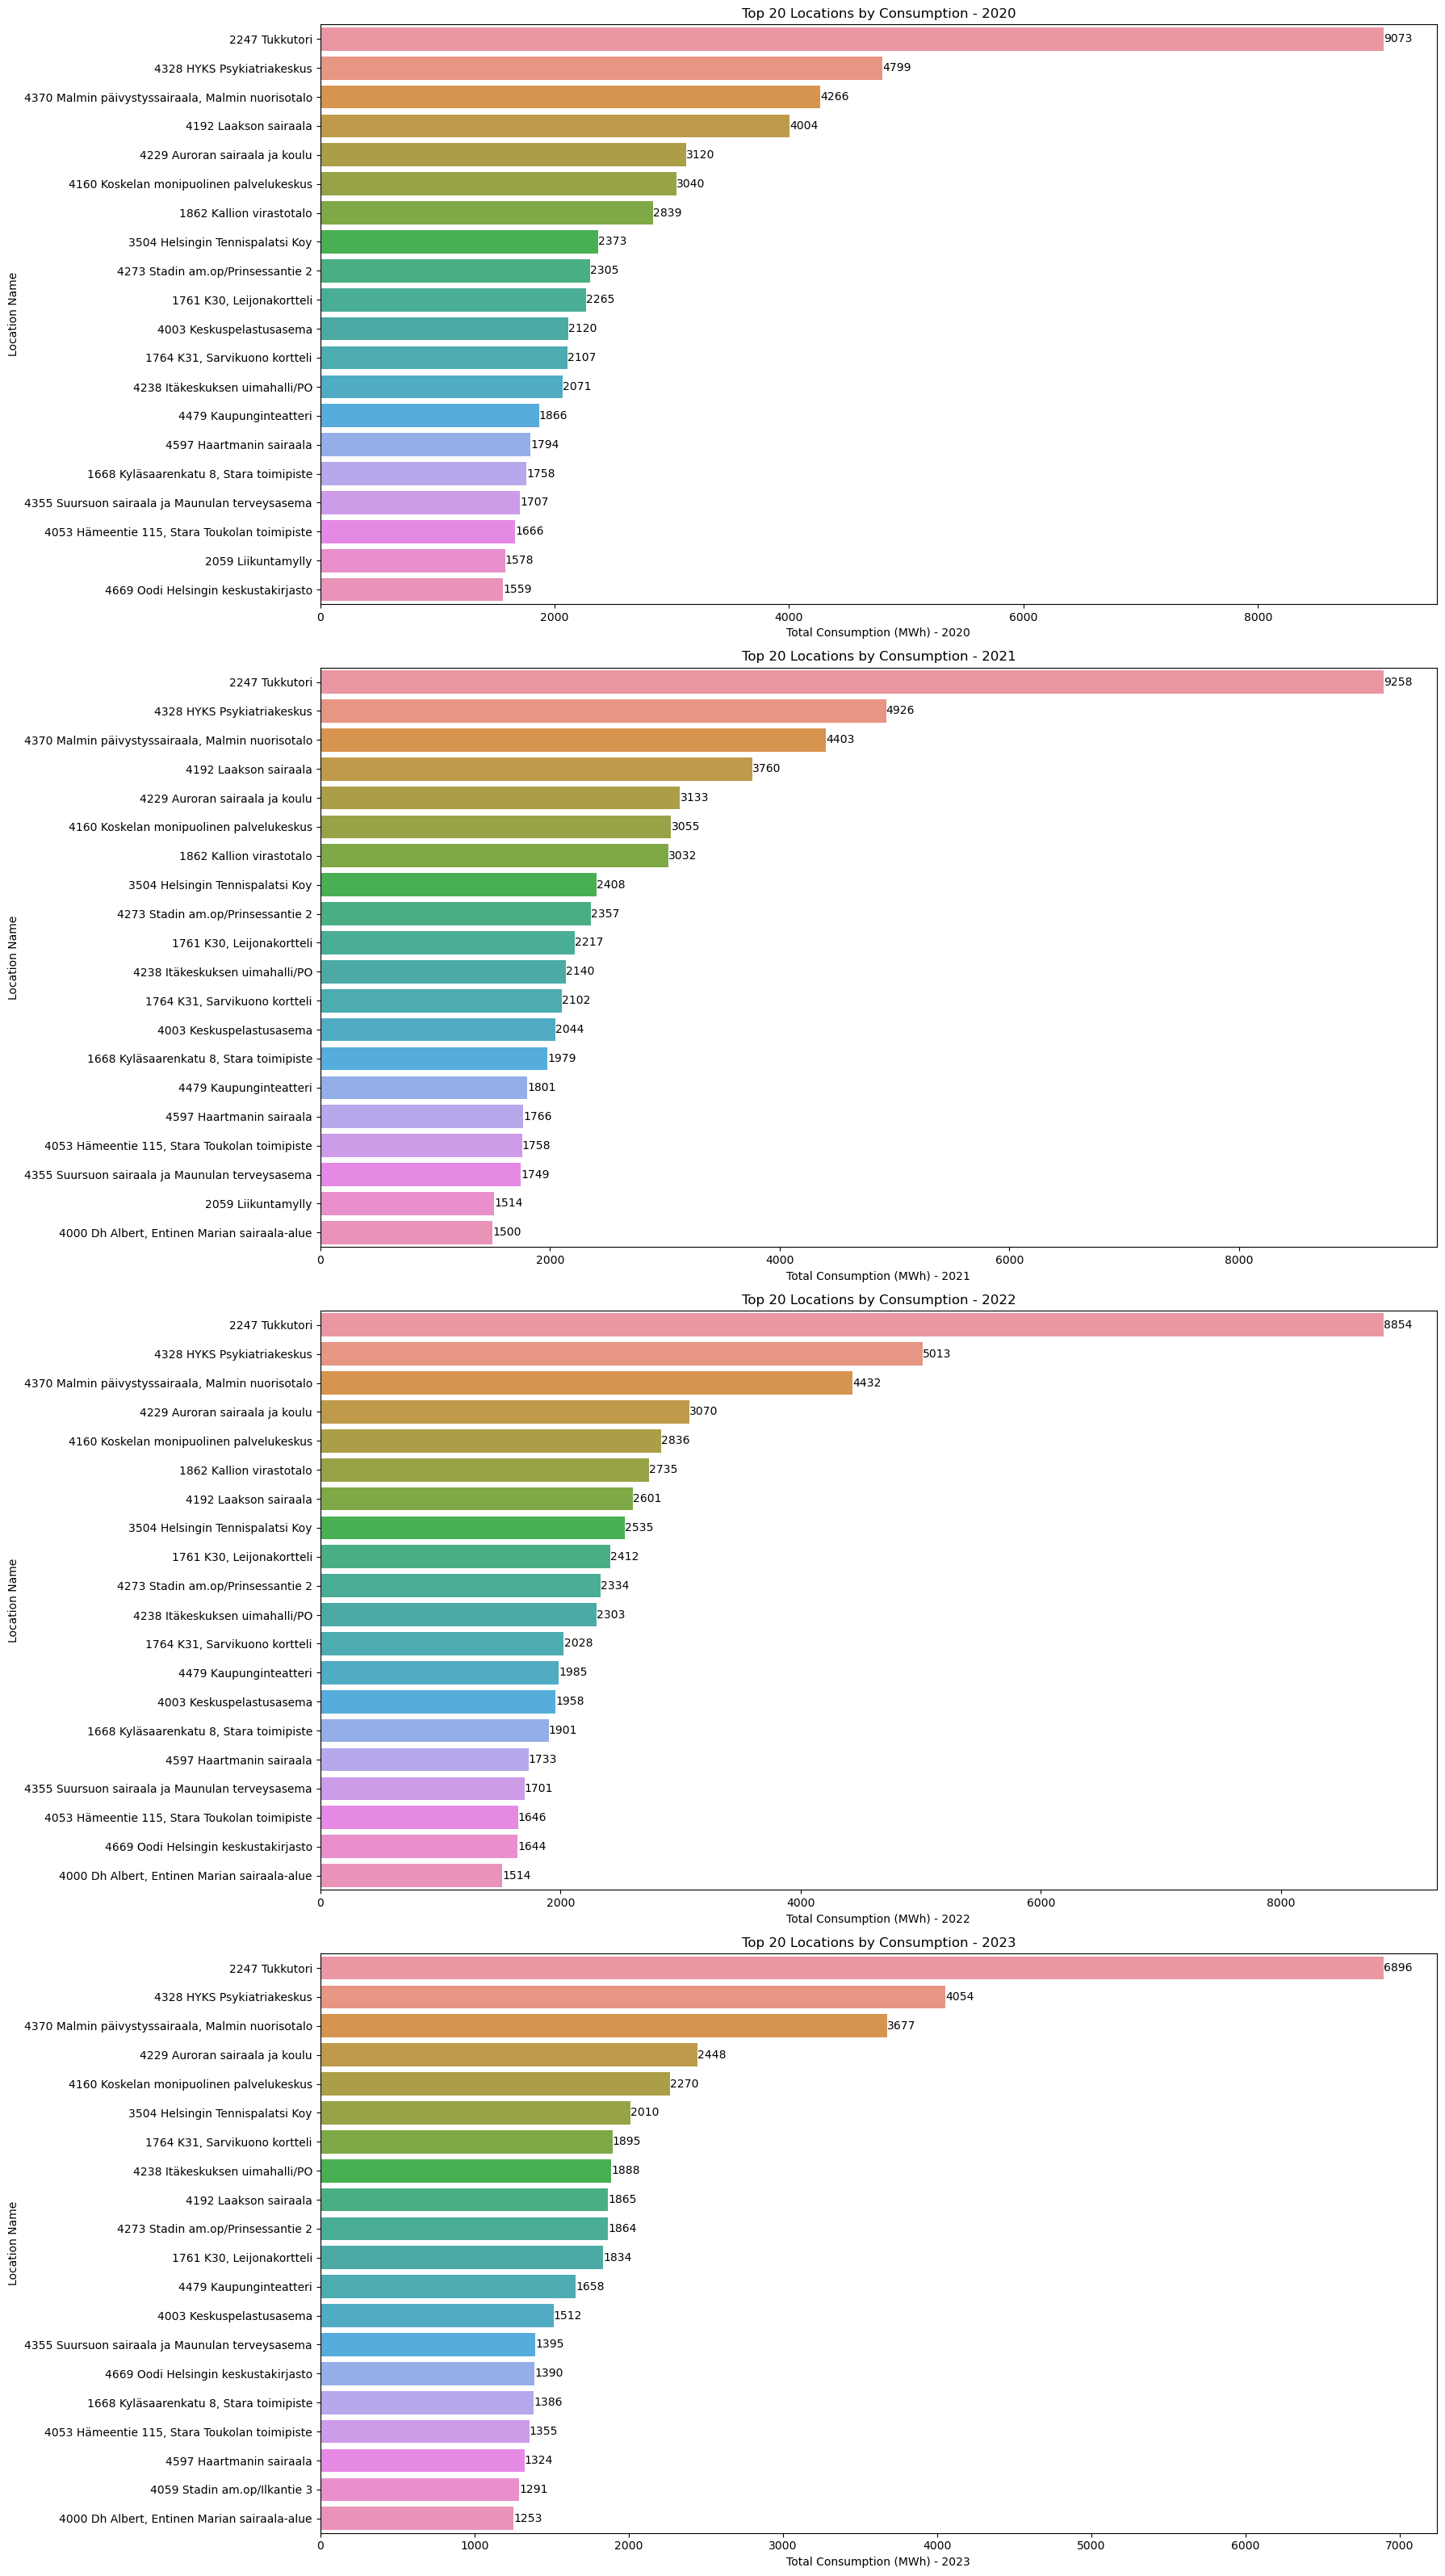

In [159]:
# List of unique years in df
unique_years = sorted(df['year'].unique(), reverse=False)

# Set up subplots
fig, axes = plt.subplots(nrows=len(unique_years), figsize=(18, 8 * len(unique_years)))

# Loop through each year and create a subplot for the top 20 locations
for i, year in enumerate(unique_years):
    yearly_data = df[df['year'] == year]
    top_locations = yearly_data.groupby('locationName')['consumption'].sum().nlargest(20) / 1000 
    
    sns.barplot(ax=axes[i], x=top_locations.values, y=top_locations.index)
    axes[i].set_xlabel(f'Total Consumption (MWh) - {year}')
    axes[i].set_ylabel('Location Name')
    axes[i].set_title(f'Top 20 Locations by Consumption - {year}')
    
    # Add consumption values of each location
    for bar, value in zip(axes[i].patches, top_locations.values):
        axes[i].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{value:.0f}', ha='left', va='center')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

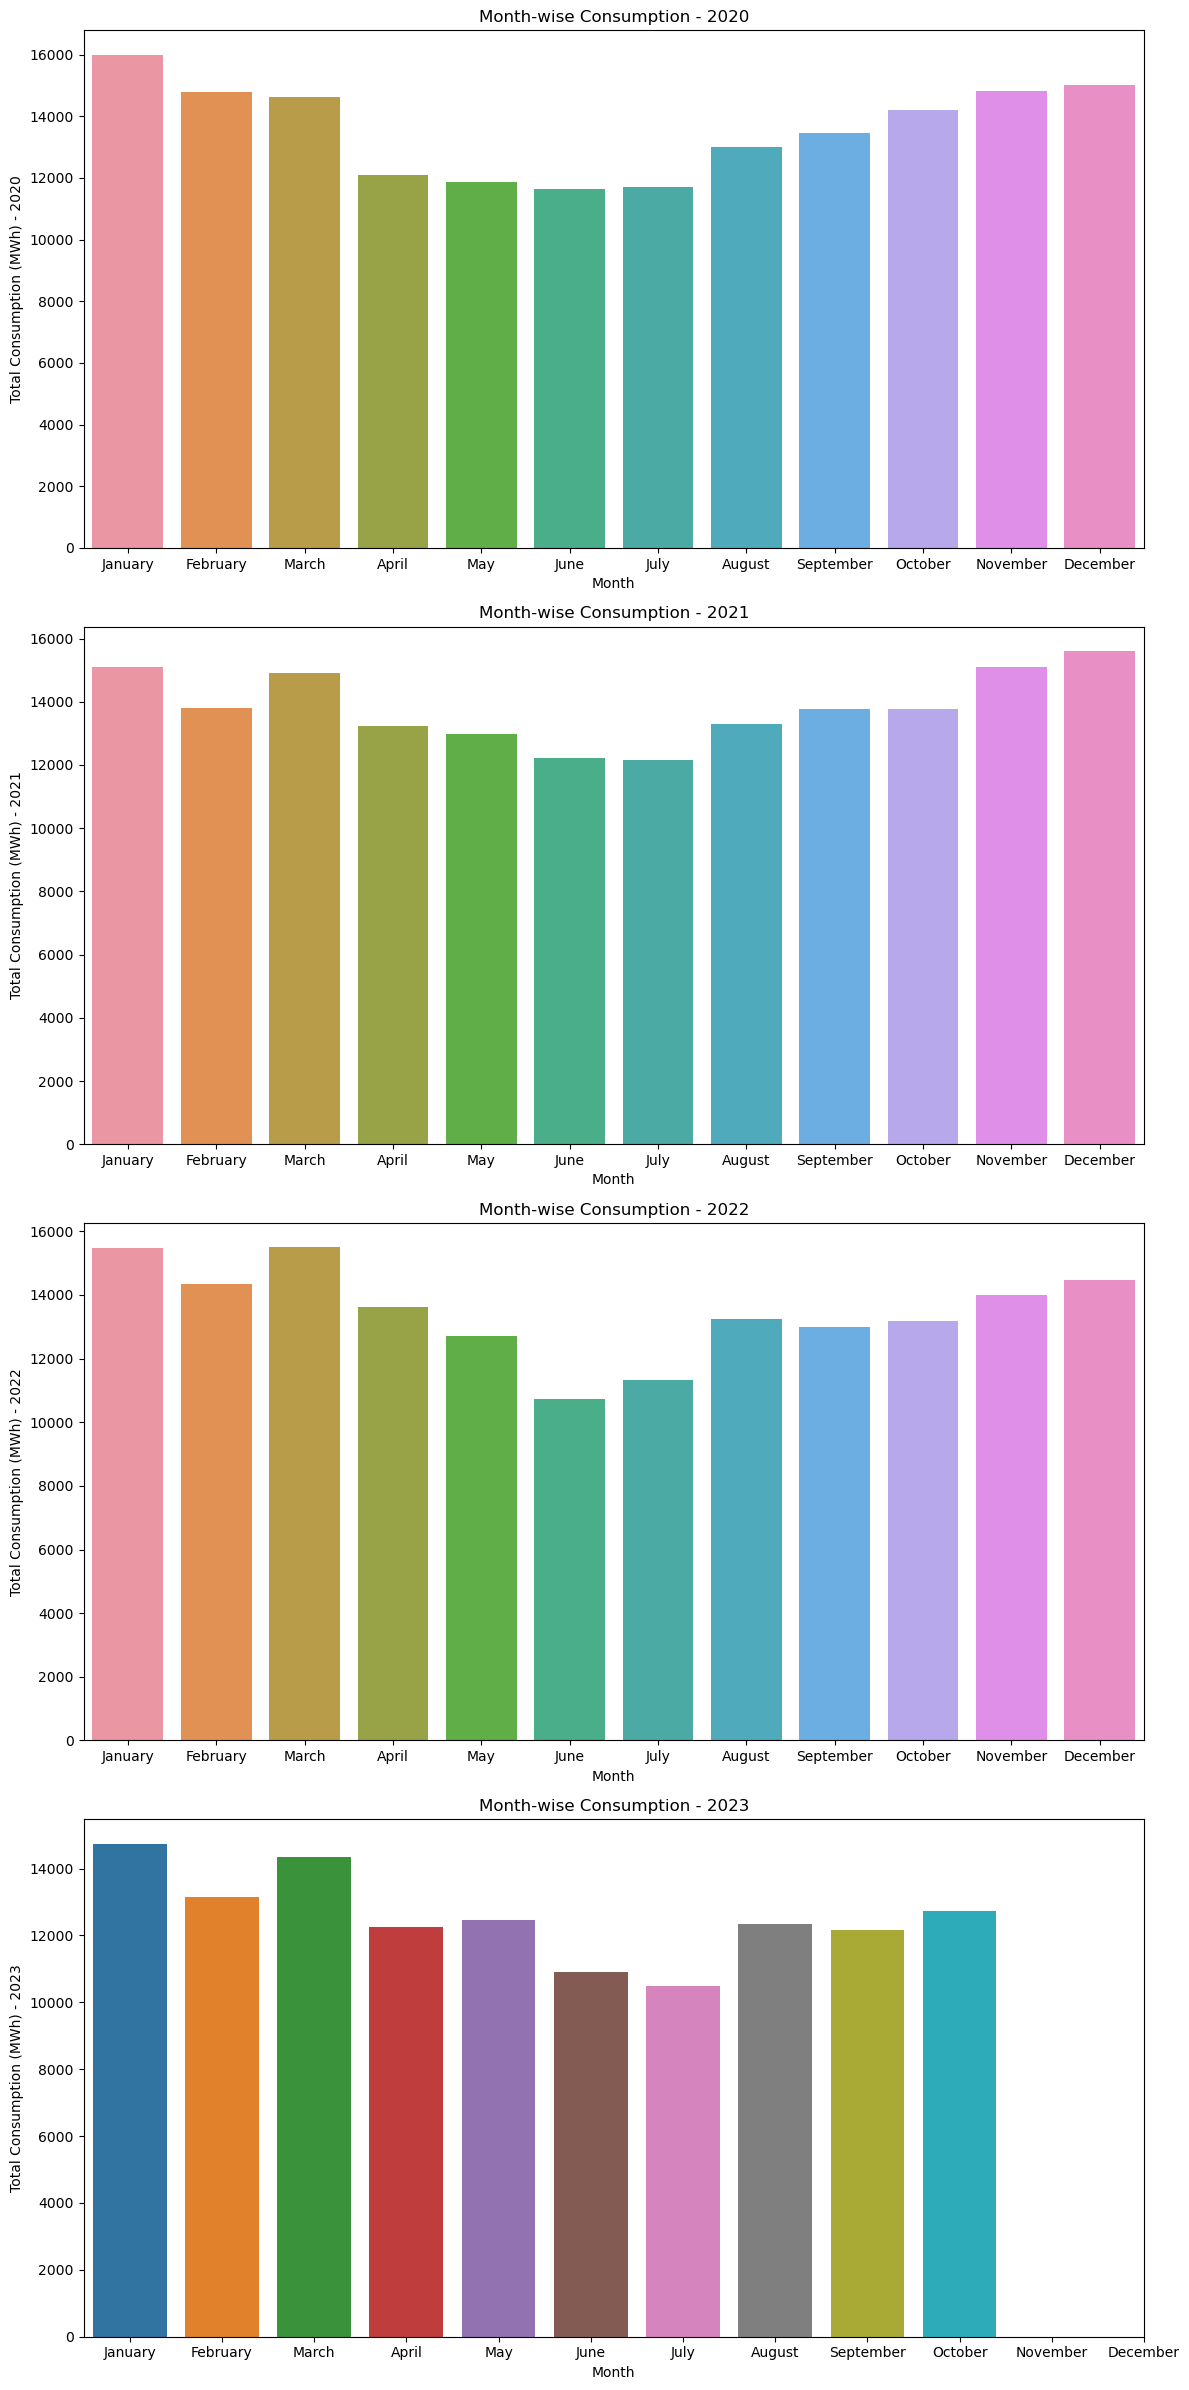

In [160]:
# Set up subplots
fig, axes = plt.subplots(nrows=len(unique_years), figsize=(12, 6 * len(unique_years)))

# Loop through each year and create a subplot for the month-wise consumption
for i, year in enumerate(unique_years):
    yearly_data = df[df['year'] == year]
    monthly_consumption = yearly_data.groupby('month')['consumption'].sum() / 1000 
    
    sns.barplot(ax=axes[i], x=monthly_consumption.index, y=monthly_consumption.values)
    axes[i].set_xticks(range(0, 12))
    axes[i].set_xticklabels([calendar.month_name[m] for m in range(1, 13)]) 
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel(f'Total Consumption (MWh) - {year}')
    axes[i].set_title(f'Month-wise Consumption - {year}')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

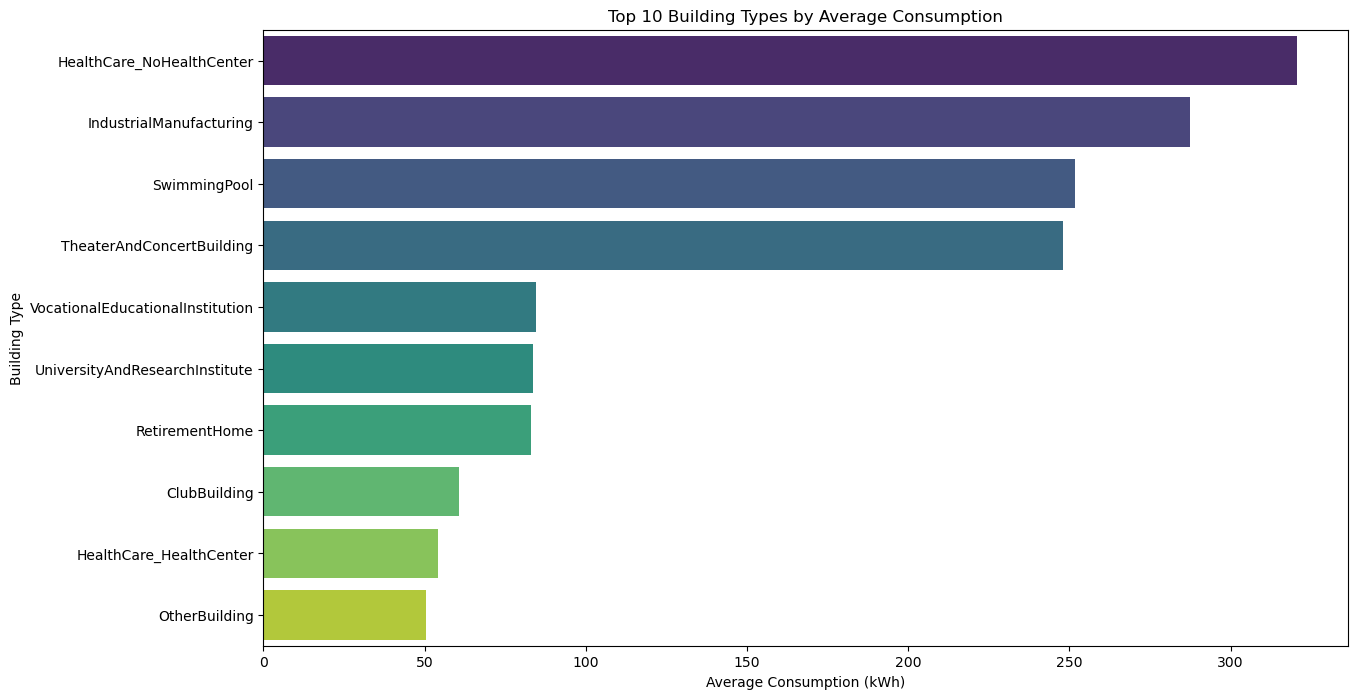

In [161]:
top_n = 10 

# Calculate average consumption for each building type
top_building_types = df.groupby('buildingType')['consumption'].mean().nlargest(top_n)

# Plot the top N building types
plt.figure(figsize=(14, 8))
sns.barplot(x=top_building_types.values, y=top_building_types.index, palette='viridis')
plt.xlabel('Average Consumption (kWh)')
plt.ylabel('Building Type')
plt.title(f'Top {top_n} Building Types by Average Consumption')
plt.show()

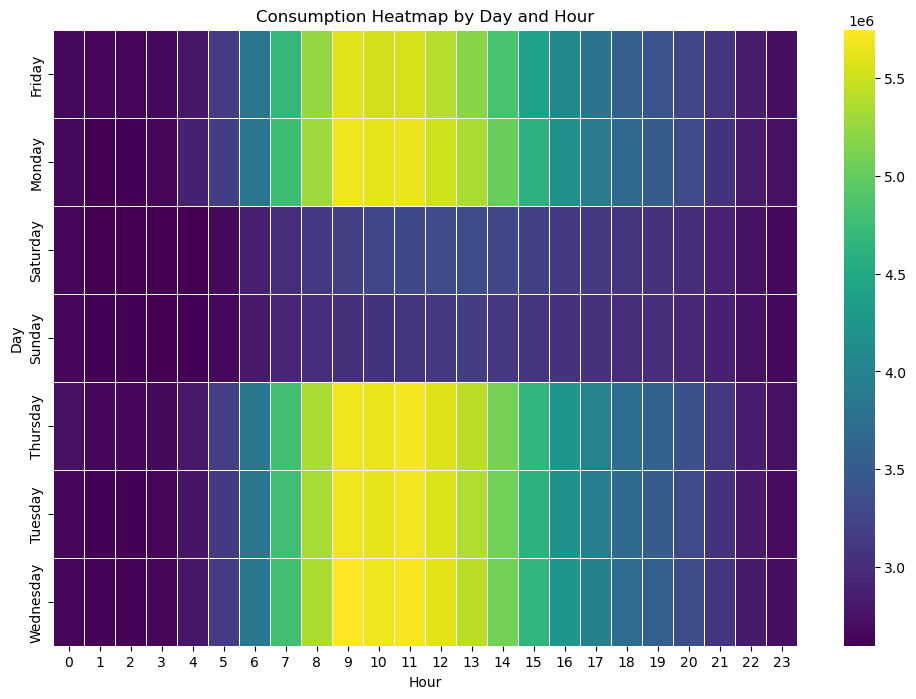

In [162]:
pivot_df = df.pivot_table(index='day', columns='hour', values='consumption', aggfunc='sum')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap='viridis', linewidths=.5)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.title('Consumption Heatmap by Day and Hour')
plt.show()

In [163]:
# H0: There is no significant difference in consumption between weekdays and weekends.
# H1: There is a significant difference in consumption between weekdays and weekends.

# Create a new column to categorize weekdays and weekends
df['weekday_category'] = np.where(df['day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday', 'weekend')

# Extract consumption data for weekdays and weekends
consumption_weekday = df.loc[df['weekday_category'] == 'weekday', 'consumption']
consumption_weekend = df.loc[df['weekday_category'] == 'weekend', 'consumption']

# Perform independent two-sample t-test
t_stat, p_value = ttest_ind(consumption_weekday, consumption_weekend, equal_var=False)

print(f'T-Statistic: {t_stat}\nP-value: {p_value}')

# Set the significance level (alpha)
alpha = 0.05

# Compare p-value with alpha to make a decision
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is a significant difference in consumption between weekdays and weekends.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is no significant difference in consumption between weekdays and weekends.")

T-Statistic: 262.17342608417295
P-value: 0.0
Reject the null hypothesis.
There is a significant difference in consumption between weekdays and weekends.


In [164]:
# H0: There is no significant difference in consumption among different building types.
# H1: There is a significant difference in consumption among different building types.

# Extract consumption data for each building type
building_types = df['buildingType'].unique()

# Create a dictionary to store consumption data for each building type
consumption_data_by_building = {building: df.loc[df['buildingType'] == building, 'consumption'] for building in building_types}

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*consumption_data_by_building.values())

print(f'F-Statistic: {f_stat}\nP-value: {p_value}')

# Set the significance level (alpha)
alpha = 0.05

# Compare p-value with alpha to make a decision
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is a significant difference in consumption among different building types.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is no significant difference in consumption among different building types.")

F-Statistic: 374156.35434789123
P-value: 0.0
Reject the null hypothesis.
There is a significant difference in consumption among different building types.
